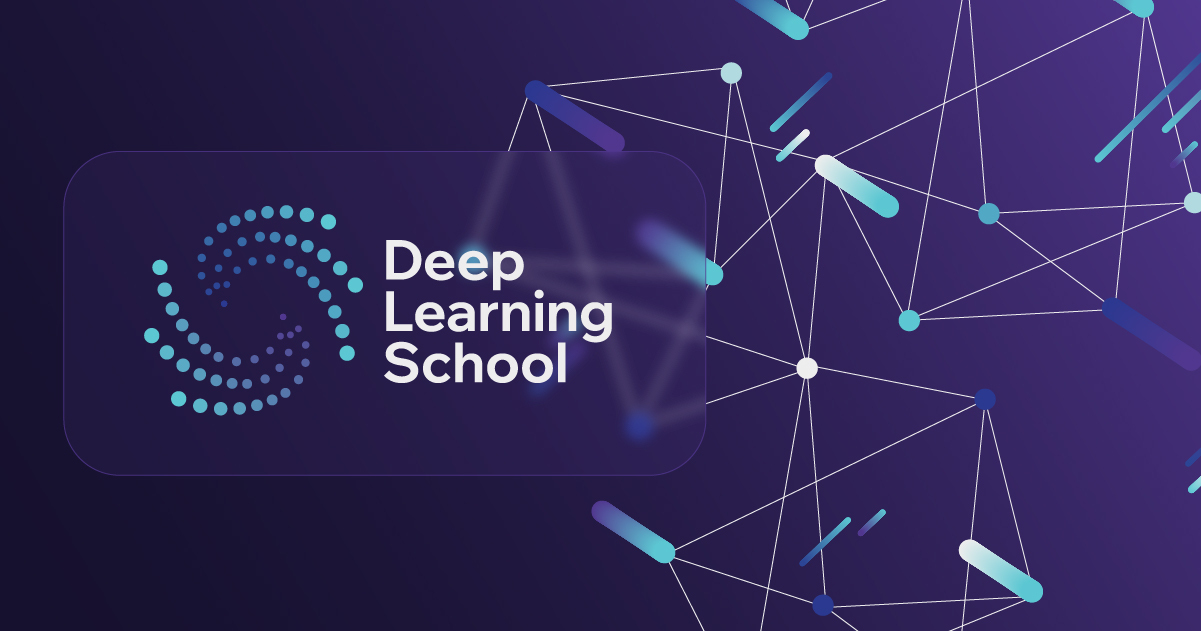


<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Классификация изображений</b></h3>


# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

### Установка зависимостей

In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive/')

In [3]:
#!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [4]:
#!ls train

In [5]:
#!ls data

In [6]:
#!ls data/train

In [2]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sun Apr  6 20:05:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P0             25W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

True

In [3]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [4]:
# это пакет для проверки версий других пакетов
import pkg_resources

In [5]:
!python --version

Python 3.10.12


In [6]:
for b in ['torch', 'torchvision', 'tqdm', 'matplotlib', 'seaborn', 'Pillow']:
    print(b + ' version: '+ pkg_resources.get_distribution(b).version)

torch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121
tqdm version: 4.67.1
matplotlib version: 3.7.5
seaborn version: 0.12.2
Pillow version: 11.0.0


#### Версии питона и библиотек, на которых работал эталонный ноутбук:

Python 3.11.11

torch version: 2.5.1+cu124

torchvision version: 0.20.1+cu124

tqdm version: 4.67.1

matplotlib version: 3.10.0

seaborn version: 0.13.2

Pillow version: 11.1.0


In [7]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

Полезная статья, которой мы вдохновились при создании класса `SimpsonsDataset`:

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/

Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

`ToTensor` конвертирует  `PIL Image` с параметрами в диапазоне $[0, 255]$ (как все пиксели) в `FloatTensor` размера ($C \times H \times W$) $[0,1]$ , затем производится масштабирование:
$\text{input} = \frac{\text{input} - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размеру (это делает метод  _prepare_sample).

Увеличим набор данных поворачивая, отражая, приближая изображения.

In [8]:
rotate = transforms.Compose([transforms.RandomRotation(degrees=30),])
h_flip = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),])
resize = transforms.Compose([transforms.RandomResizedCrop(size=224,scale=(0.8, 1.0)),])
change_color = transforms.Compose([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),])

changes = [rotate, h_flip, resize, change_color]

In [14]:
#!rm -r /kaggle/working/augmented_dataset

In [9]:
#transforming and saving images here
import os

folder_path = "/kaggle/input/journey-springfield/train/simpsons_dataset"  
augment_folder = "/kaggle/working/augmented_dataset"  


os.makedirs(augment_folder, exist_ok=True)


for class_name in os.listdir(folder_path):  
    class_path = os.path.join(folder_path, class_name)

    if os.path.isdir(class_path):
        augment_class_path = os.path.join(augment_folder, class_name)
        os.makedirs(augment_class_path, exist_ok=True)

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            image = Image.open(img_path).convert("RGB")
            new_img_name = f"orig_{img_name}"
            image.save(os.path.join(augment_class_path, new_img_name))
            for i, change in enumerate(changes):
                new_image = change(image)
                new_img_name = f"{i}_{img_name}"
                new_image.save(os.path.join(augment_class_path, new_img_name))
                
                

print("Все изображения преобразованы и сохранены в новой папке!")

Все изображения преобразованы и сохранены в новой папке!


In [10]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [11]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [12]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('/kaggle/input/journey-springfield/train/simpsons_dataset')
TRAIN_TRANSFORMED_DIR = Path('/kaggle/working/augmented_dataset')
TEST_DIR = Path('/kaggle/input/journey-springfield/testset/testset')

In [13]:
train_val_files = sorted(list(TRAIN_TRANSFORMED_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [14]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [15]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [22]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Для увеличения датасета будем поворачивать, отражать, приближать изображения.

**!** Обратите внимание, что возможно, датасет требует дополнительной фильтрации, так как лейблы не всегда точно соответствуют картинкам.

Давайте посмотрим на наших героев внутри датасета.

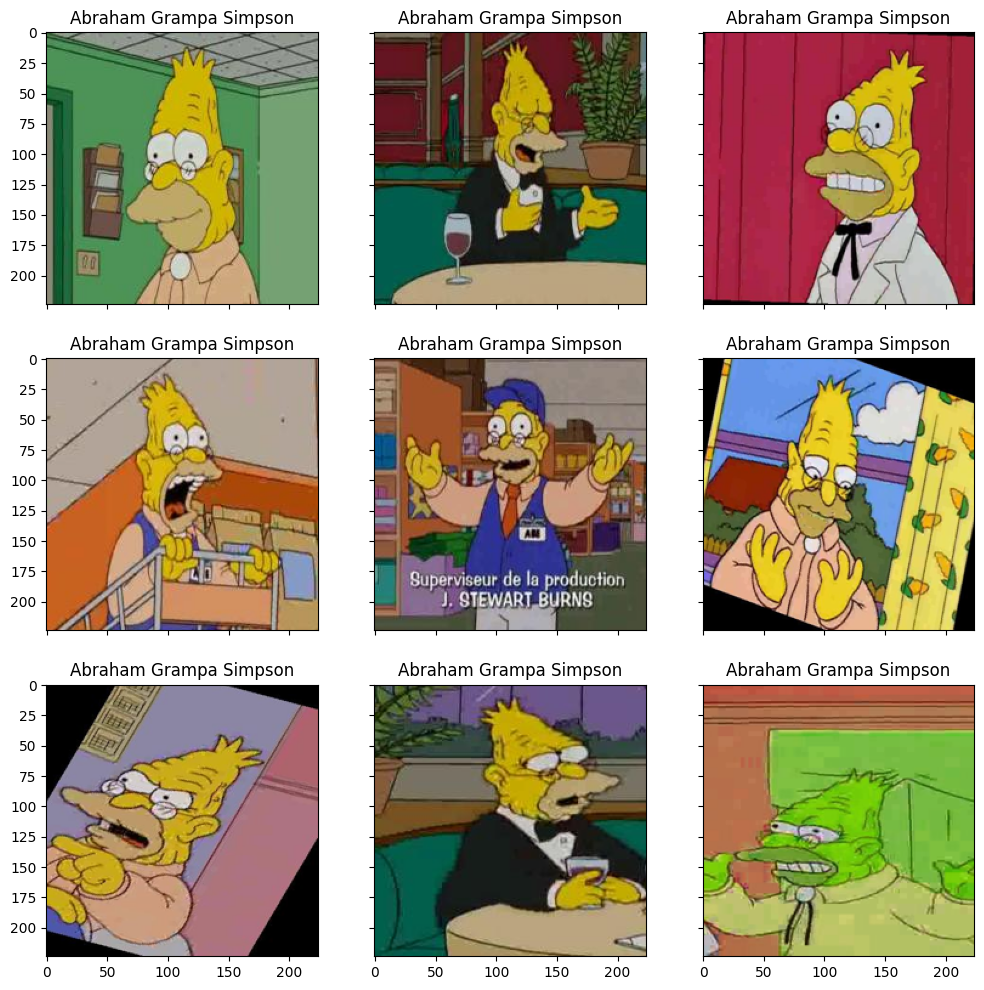

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle.

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: $3\times 224 \times 224$
2.размерности после слоя:  $8 \times 111 \times 111$
3. $16 \times 54 \times 54$
4. $32 \times 26 \times 26$
5. $64 \times 12 \times 12$
6. выход: $96 \times 5 \times 5$

О том, как работают свёртки подробней можно прочитать в документации Pytorch на функцию `Conv2d`:

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

Калькулятор свёрток:

https://madebyollin.github.io/convnet-calculator/

#### Модель

In [88]:
class Block(nn.Module):
    def __init__(self,in_chan,out_chan, downsample=None):
        super().__init__()
        self.downsample = downsample
        self.conv1 = nn.Conv2d(in_channels = in_chan, out_channels = out_chan, kernel_size=3,padding=2)
        self.conv2 = nn.Conv2d(in_channels = out_chan, out_channels = out_chan, kernel_size=3,padding=1)
        self.bn1 = nn.BatchNorm2d(out_chan)
        self.bn2 = nn.BatchNorm2d(out_chan)
        self.pool = nn.MaxPool2d(kernel_size=3,stride=2)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        residual = x
        x = self.activation(self.bn1(self.conv1(x)))
        x = self.activation(self.bn2(self.conv2(x)))
        x = self.bn2(self.pool(x)) #using same batch norm because number of channels doesn't change
        if self.downsample is not None:
            residual = self.downsample(residual)
        x += residual
        return x
            
class MyNN_V2(nn.Module):
     def __init__(self, block, n_classes):
        
        super(MyNN_V2, self).__init__()
        self.block=block
        self.layer1 = self._make_layer(3,8)
        self.layer2 = self._make_layer(8,16)
        self.layer3 = self._make_layer(16,32)
        self.layer4 = self._make_layer(32,64)
        self.layer5 = self._make_layer(64,128)

        self.activation = nn.ReLU()
         
        self.flat=nn.Flatten(start_dim=1)
        self.fc1=nn.Linear(12544,512) 
        self.fc2=nn.Linear(512,512)
        self.out=nn.Linear(512,n_classes)

        self.fc_bn1 = nn.BatchNorm1d(512)
        self.fc_bn2 = nn.BatchNorm1d(512)
        self.fc_bn3 = nn.BatchNorm1d(n_classes)
    
     def _make_layer(self, in_chan, out_chan, stride=2):
        downsample = nn.Sequential(
            nn.Conv2d(in_channels=in_chan, out_channels=out_chan, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_chan)
        )
        layers = []
        layers.append(self.block(in_chan, out_chan, downsample))
    
        return nn.Sequential(*layers)

         

     def forward(self, x):
         x = self.layer1(x)
         x = self.layer2(x)
         x = self.layer3(x)
         x = self.layer4(x)
         
         x = self.flat(x)
         
         #print('shape after flatten', x.shape) #x.shape = 64*12544 -> firs linear layer in_features=512
         x = self.activation(self.fc_bn1(self.fc1(x)))
         x = self.activation(self.fc_bn2(self.fc2(x)))
         x = self.activation(self.fc_bn3(self.out(x)))
         return x

#### Функция обучения:

In [31]:
def fit_epoch(model, train_loader, criterion, optimizer):
    """
    Функция обучает модель на одной эпохе, используя предоставленный dataloader.

    Эта функция проходит по всем данным в `train_loader`, выполняет шаг моделью (forward),
    вычисляет лосс, выполняет обратное распространение с помощью заданного
    оптимизатора и обновляет веса модели.
    В конце эпохи возвращаются средний лосс и
    точность на обучающем наборе данных.

    Параметры:
    ----------
    model : nn.Module
        Модель, которую необходимо обучить. Должна быть экземпляром класса
        PyTorch `nn.Module`.

    train_loader : DataLoader
        Загрузчик данных, который предоставляет батчи входных данных и
        соответствующих меток. Должен возвращать кортежи (inputs, labels).

    criterion : nn.Module
        Функция потерь, используемая для вычисления ошибки между
        предсказаниями модели и истинными метками.

    optimizer : torch.optim.Optimizer
        Оптимизатор, используемый для обновления весов модели на основе
        градиентов, вычисленных в процессе обучения.

    Функция возвращает:
    ----------
    tuple
        Кортеж, содержащий средний лосс (train_loss) и точность (train_acc)
        на обучающем наборе данных за текущую эпоху.
    """

    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    i=0

    for inputs, labels in train_loader:

        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
        if i%100 == 0 :
            print(f'train  batch number {i}')
            print(f'train loss = {running_loss / processed_data}')
            print(f'train accuracy = {running_corrects.cpu().numpy() / processed_data}')
        i+=1    

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

#### Функция валидации:

In [32]:
def eval_epoch(model, val_loader, criterion):
    """
    Функция оценивает работу модели на валидационном наборе данных за одну эпоху.

    Эта функция проходит по всем данным в `val_loader`, выполняет прямое
    распространение, вычисляет лосс и точность модели. В конце эпохи
    возвращаются средний лосс и точность на валидационном наборе данных.

    Параметры:
    ----------
    model : nn.Module
        Модель, которую необходимо оценить. Должна быть экземпляром класса
        PyTorch `nn.Module`.

    val_loader : DataLoader
        Загрузчик данных, который предоставляет батчи входных данных и
        соответствующих меток для валидации. Должен возвращать кортежи
        (inputs, labels).

    criterion : nn.Module
        Функция потерь, используемая для вычисления ошибки между
        предсказаниями модели и истинными метками.

    Функция возвращает:
    ----------
    tuple
        Кортеж, содержащий среднюю потерю (val_loss) и точность (val_acc)
        на валидационном наборе данных за текущую эпоху.
    """
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    i=0
    
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
        if i%100 == 0 :
            print(f'batch number {i}')
            print(f'validation loss = {running_loss / processed_size}')
            print(f'validation accuracy = {running_corrects.double() / processed_size}')
        i+=1    
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

#### Полный цикл обучения

In [33]:
def train(train_files, val_files, model, epochs, batch_size):
    """
    Функция обучает модель на обучающем наборе данных и оценивает ее на валидационном наборе данных.

    Эта функция создает загрузчики данных для обучающего и валидационного наборов,
    а затем выполняет обучение модели в течение заданного количества эпох.
    В конце каждой эпохи выводятся значения потерь и точности для обучающего и
    валидационного наборов. История обучения сохраняется и возвращается.

    Параметры:
    ----------
    train_files : list
        Список файлов или путей к файлам, содержащим обучающие данные.

    val_files : list
        Список файлов или путей к файлам, содержащим валидационные данные.

    model : nn.Module
        Модель, которую необходимо обучить. Должна быть экземпляром класса
        PyTorch `nn.Module`.

    epochs : int
        Количество эпох для обучения модели.

    batch_size : int
        Размер батча, используемый для загрузки данных.

    Возвращает:
    ----------
    list
        Список, содержащий кортежи (train_loss, train_acc, val_loss, val_acc)
        для каждой эпохи, где:
        - train_loss: средняя потеря на обучающем наборе.
        - train_acc: точность на обучающем наборе.
        - val_loss: средняя потеря на валидационном наборе.
        - val_acc: точность на валидационном наборе.
    """
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

#### Применение модели к данным

In [34]:
def predict(model, test_loader):
    """
    Функция выполняет предсказание классов для тестового набора данных с использованием обученной модели.

    Эта функция принимает модель и загрузчик тестовых данных, применяет модель к
    изображениям и возвращает вероятности предсказанных классов.

    Параметры:
    ----------
    model : nn.Module
        Обученная модель, которая будет использоваться для предсказания.
        Должна быть экземпляром класса PyTorch `nn.Module`.

    test_loader : DataLoader
        Загрузчик данных, который предоставляет батчи входных данных для тестирования.
        Должен возвращать тензоры входных данных.

    Возвращает:
    ----------
    numpy.ndarray
        Массив вероятностей предсказанных классов для каждого примера в тестовом наборе.
        Размерность массива будет (N, C), где N - количество примеров, а C - количество классов.
    """

    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [89]:
n_classes = len(np.unique(train_val_labels))
my_cnn_v2 = MyNN_V2(block=Block, n_classes=n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(my_cnn_v2)

we will classify :42
MyNN_V2(
  (layer1): Sequential(
    (0): Block(
      (downsample): Sequential(
        (0): Conv2d(3, 8, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
      (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (activation): ReLU()
    )
  )
  (layer2): Sequential(
    (0): Block(
      (downsample): Sequential(
        (0): Conv2d(8, 16, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (con

Запустим обучение сети.

In [90]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [91]:
history = train(train_dataset, val_dataset, model=my_cnn_v2, epochs=10, batch_size=64)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

train  batch number 0
train loss = 4.010685920715332
train accuracy = 0.015625
train  batch number 100
train loss = 2.8223761756821433
train accuracy = 0.3626237623762376
train  batch number 200
train loss = 2.44669309836715
train accuracy = 0.45810012437810943
train  batch number 300
train loss = 2.21530422261387
train accuracy = 0.51531353820598
train  batch number 400
train loss = 2.039708486221675
train accuracy = 0.5580190149625935
train  batch number 500
train loss = 1.8995868524391495
train accuracy = 0.5898827345309381
train  batch number 600
train loss = 1.7812978752242548
train accuracy = 0.6165505407653911
train  batch number 700
train loss = 1.680457108371098
train accuracy = 0.6391761768901569
train  batch number 800
train loss = 1.5940241545773624
train accuracy = 0.65812265917603
train  batch number 900
train loss = 1.5158250746001942
train accuracy = 0.6751526082130965
train  batch number 1000
train loss = 1.4470952051383752
train accuracy = 0.6897633616383616
train  ba

epoch:  10%|█         | 1/10 [08:47<1:19:08, 527.63s/it]


Epoch 001 train_loss: 1.3144     val_loss 2.9022 train_acc 0.7187 val_acc 0.3033
train  batch number 0
train loss = 2.625054359436035
train accuracy = 0.40625
train  batch number 100
train loss = 0.7380120019511421
train accuracy = 0.8033725247524752
train  batch number 200
train loss = 0.6103077215045246
train accuracy = 0.8367537313432836
train  batch number 300
train loss = 0.5600557204496821
train accuracy = 0.8494082225913622
train  batch number 400
train loss = 0.5154063952273858
train accuracy = 0.8613232543640897
train  batch number 500
train loss = 0.4906572636343286
train accuracy = 0.8687312874251497
train  batch number 600
train loss = 0.4671285009498207
train accuracy = 0.8748700083194676
train  batch number 700
train loss = 0.4477224803706379
train accuracy = 0.8797922610556348
train  batch number 800
train loss = 0.4276894117506702
train accuracy = 0.885026529338327
train  batch number 900
train loss = 0.4099284885668265
train accuracy = 0.8896018312985572
train  batch 

epoch:  20%|██        | 2/10 [17:26<1:09:41, 522.68s/it]


Epoch 002 train_loss: 0.3733     val_loss 0.3058 train_acc 0.8990 val_acc 0.9186
train  batch number 0
train loss = 0.09696883708238602
train accuracy = 0.984375
train  batch number 100
train loss = 0.10705699991102856
train accuracy = 0.9719987623762376
train  batch number 200
train loss = 0.10682441972993055
train accuracy = 0.9710043532338308
train  batch number 300
train loss = 0.10661428787148375
train accuracy = 0.9716050664451827
train  batch number 400
train loss = 0.1086175737187192
train accuracy = 0.970464463840399
train  batch number 500
train loss = 0.11245705763216385
train accuracy = 0.969061876247505
train  batch number 600
train loss = 0.11912001572710504
train accuracy = 0.9672160981697171
train  batch number 700
train loss = 0.11946954055637461
train accuracy = 0.9665433309557775
train  batch number 800
train loss = 0.12247462792626666
train accuracy = 0.9656679151061174
train  batch number 900
train loss = 0.12377546266750841
train accuracy = 0.9654203662597114
tra

epoch:  30%|███       | 3/10 [26:05<1:00:46, 520.87s/it]


Epoch 003 train_loss: 0.1312     val_loss 0.2640 train_acc 0.9632 val_acc 0.9300
train  batch number 0
train loss = 0.056553151458501816
train accuracy = 0.984375
train  batch number 100
train loss = 0.07640053773077556
train accuracy = 0.9800433168316832
train  batch number 200
train loss = 0.07562198092007259
train accuracy = 0.9798662935323383
train  batch number 300
train loss = 0.0733254633300885
train accuracy = 0.979703073089701
train  batch number 400
train loss = 0.07292611937635483
train accuracy = 0.9797381546134664
train  batch number 500
train loss = 0.08142808091686388
train accuracy = 0.9773577844311377
train  batch number 600
train loss = 0.08560869866999923
train accuracy = 0.97608153078203
train  batch number 700
train loss = 0.08485219835356202
train accuracy = 0.9759495363766049
train  batch number 800
train loss = 0.08636652715239655
train accuracy = 0.9754798689138576
train  batch number 900
train loss = 0.08778959183918042
train accuracy = 0.9748890122086571
tra

epoch:  40%|████      | 4/10 [34:48<52:09, 521.66s/it]  


Epoch 004 train_loss: 0.0941     val_loss 0.2576 train_acc 0.9731 val_acc 0.9353
train  batch number 0
train loss = 0.050377052277326584
train accuracy = 0.984375
train  batch number 100
train loss = 0.06759140013929198
train accuracy = 0.9798886138613861
train  batch number 200
train loss = 0.05983569230988566
train accuracy = 0.9822761194029851
train  batch number 300
train loss = 0.06718232244735838
train accuracy = 0.9799107142857143
train  batch number 400
train loss = 0.06968524164672328
train accuracy = 0.979231608478803
train  batch number 500
train loss = 0.0710535602889929
train accuracy = 0.9785117265469062
train  batch number 600
train loss = 0.07312296140809604
train accuracy = 0.9781094009983361
train  batch number 700
train loss = 0.07502534120099834
train accuracy = 0.9777327032810271
train  batch number 800
train loss = 0.07456029352781998
train accuracy = 0.9777426654182272
train  batch number 900
train loss = 0.0795378261279381
train accuracy = 0.9765191453940066
tr

epoch:  50%|█████     | 5/10 [43:29<43:27, 521.53s/it]


Epoch 005 train_loss: 0.0789     val_loss 0.2823 train_acc 0.9770 val_acc 0.9345
train  batch number 0
train loss = 0.002303691813722253
train accuracy = 1.0
train  batch number 100
train loss = 0.049519880710510854
train accuracy = 0.9862314356435643
train  batch number 200
train loss = 0.045865089105226714
train accuracy = 0.9868625621890548
train  batch number 300
train loss = 0.04413243997076285
train accuracy = 0.9869186046511628
train  batch number 400
train loss = 0.04846551753708308
train accuracy = 0.9854660224438903
train  batch number 500
train loss = 0.048223008401924276
train accuracy = 0.9854041916167665
train  batch number 600
train loss = 0.05074230975619813
train accuracy = 0.9846869800332779
train  batch number 700
train loss = 0.05710784275177401
train accuracy = 0.9825918330955777
train  batch number 800
train loss = 0.06094703771958486
train accuracy = 0.9813319288389513
train  batch number 900
train loss = 0.06644999504366633
train accuracy = 0.9799181465038845
t

epoch:  60%|██████    | 6/10 [52:08<34:42, 520.68s/it]


Epoch 006 train_loss: 0.0680     val_loss 0.2411 train_acc 0.9800 val_acc 0.9468
train  batch number 0
train loss = 0.1019994467496872
train accuracy = 0.96875
train  batch number 100
train loss = 0.047336344881139414
train accuracy = 0.9863861386138614
train  batch number 200
train loss = 0.0465327949200242
train accuracy = 0.9867070895522388
train  batch number 300
train loss = 0.04995437585777256
train accuracy = 0.9858803986710963
train  batch number 400
train loss = 0.05095644809008896
train accuracy = 0.9854660224438903
train  batch number 500
train loss = 0.0526728128422624
train accuracy = 0.984936377245509
train  batch number 600
train loss = 0.05267331781179926
train accuracy = 0.9848169717138103
train  batch number 700
train loss = 0.053874283235823786
train accuracy = 0.9844195791726106
train  batch number 800
train loss = 0.053837807691694495
train accuracy = 0.9844725343320849
train  batch number 900
train loss = 0.054918534316451814
train accuracy = 0.9841148723640399
t

epoch:  70%|███████   | 7/10 [1:00:49<26:01, 520.63s/it]


Epoch 007 train_loss: 0.0573     val_loss 0.2861 train_acc 0.9834 val_acc 0.9360
train  batch number 0
train loss = 0.15687619149684906
train accuracy = 0.953125
train  batch number 100
train loss = 0.053777321840585715
train accuracy = 0.9854579207920792
train  batch number 200
train loss = 0.045795451944033075
train accuracy = 0.9867848258706468
train  batch number 300
train loss = 0.04115038634042391
train accuracy = 0.9879568106312292
train  batch number 400
train loss = 0.04371692413664541
train accuracy = 0.9872973815461347
train  batch number 500
train loss = 0.04626030749183743
train accuracy = 0.986745259481038
train  batch number 600
train loss = 0.046535123724523286
train accuracy = 0.986662853577371
train  batch number 700
train loss = 0.04489364267877197
train accuracy = 0.9869605920114123
train  batch number 800
train loss = 0.04602669338606568
train accuracy = 0.9868523720349563
train  batch number 900
train loss = 0.04669401330099898
train accuracy = 0.9865600721420644

epoch:  80%|████████  | 8/10 [1:09:35<17:24, 522.26s/it]


Epoch 008 train_loss: 0.0536     val_loss 0.2376 train_acc 0.9847 val_acc 0.9479
train  batch number 0
train loss = 0.010142067447304726
train accuracy = 1.0
train  batch number 100
train loss = 0.03742266704137022
train accuracy = 0.9891707920792079
train  batch number 200
train loss = 0.038166566373402745
train accuracy = 0.9891169154228856
train  batch number 300
train loss = 0.03844463272018577
train accuracy = 0.9893583887043189
train  batch number 400
train loss = 0.036776466432930824
train accuracy = 0.9898301122194514
train  batch number 500
train loss = 0.037510633499285705
train accuracy = 0.9893650199600799
train  batch number 600
train loss = 0.03936155699738266
train accuracy = 0.9888467138103162
train  batch number 700
train loss = 0.03877276891641529
train accuracy = 0.9888774964336662
train  batch number 800
train loss = 0.0419036056338948
train accuracy = 0.9880032771535581
train  batch number 900
train loss = 0.04373159925933489
train accuracy = 0.9876005826859046
tr

epoch:  90%|█████████ | 9/10 [1:18:18<08:42, 522.55s/it]


Epoch 009 train_loss: 0.0465     val_loss 0.2547 train_acc 0.9869 val_acc 0.9461
train  batch number 0
train loss = 0.004210956860333681
train accuracy = 1.0
train  batch number 100
train loss = 0.04843693330398724
train accuracy = 0.9877784653465347
train  batch number 200
train loss = 0.042166949022982375
train accuracy = 0.9889614427860697
train  batch number 300
train loss = 0.042135333678356576
train accuracy = 0.9883720930232558
train  batch number 400
train loss = 0.03978626771892149
train accuracy = 0.9884273690773068
train  batch number 500
train loss = 0.04240429059017426
train accuracy = 0.9878056387225549
train  batch number 600
train loss = 0.041459892877263434
train accuracy = 0.9881447587354409
train  batch number 700
train loss = 0.041320882485650745
train accuracy = 0.9881196504992867
train  batch number 800
train loss = 0.04354823635374932
train accuracy = 0.9874765917602997
train  batch number 900
train loss = 0.04728119155437612
train accuracy = 0.9865947558268591


epoch: 100%|██████████| 10/10 [1:27:00<00:00, 522.01s/it]


Epoch 010 train_loss: 0.0484     val_loss 0.2780 train_acc 0.9861 val_acc 0.9420


Построим кривые обучения

In [92]:
loss, acc, val_loss, val_acc = zip(*history)

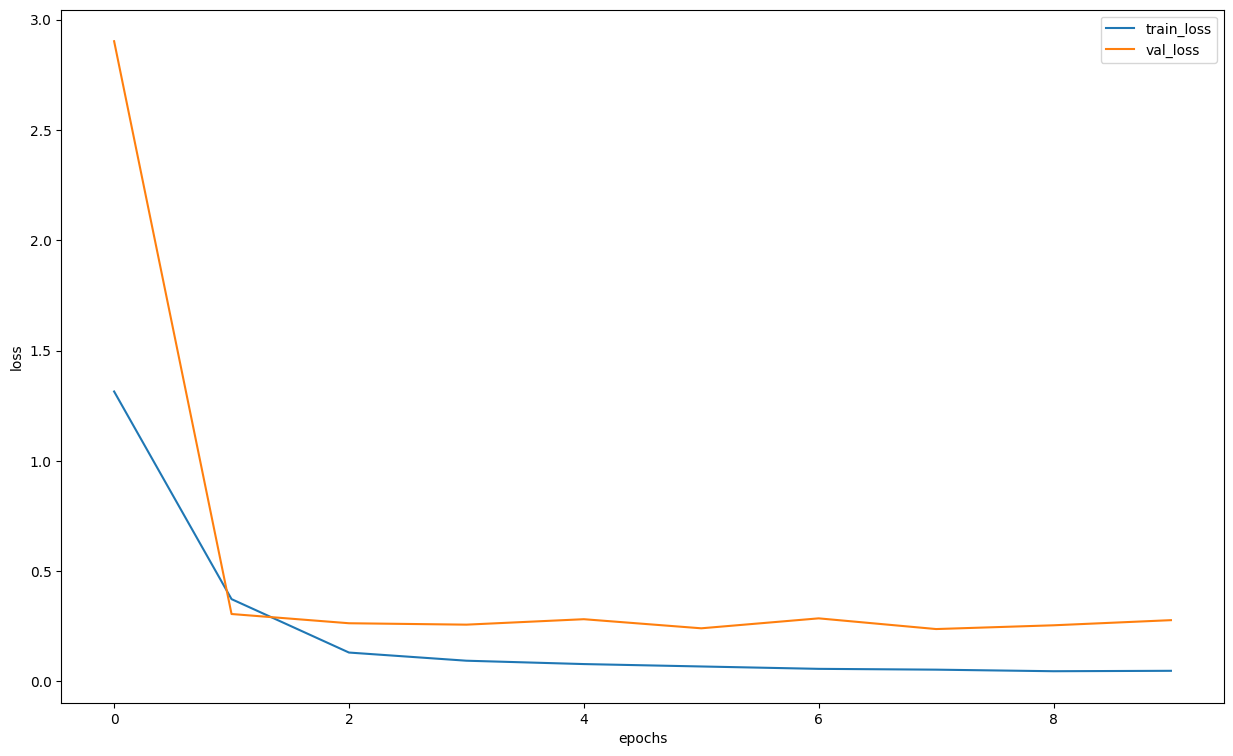

In [93]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит `softmax`, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [94]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [95]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(my_cnn_v2, ex_img.unsqueeze(0))

In [96]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(my_cnn_v2, imgs)

In [97]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [98]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе -- `f1-score`.

Вычислим целевую метрику на валидационной выборке.

In [99]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

F1-оценка: 1.0


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

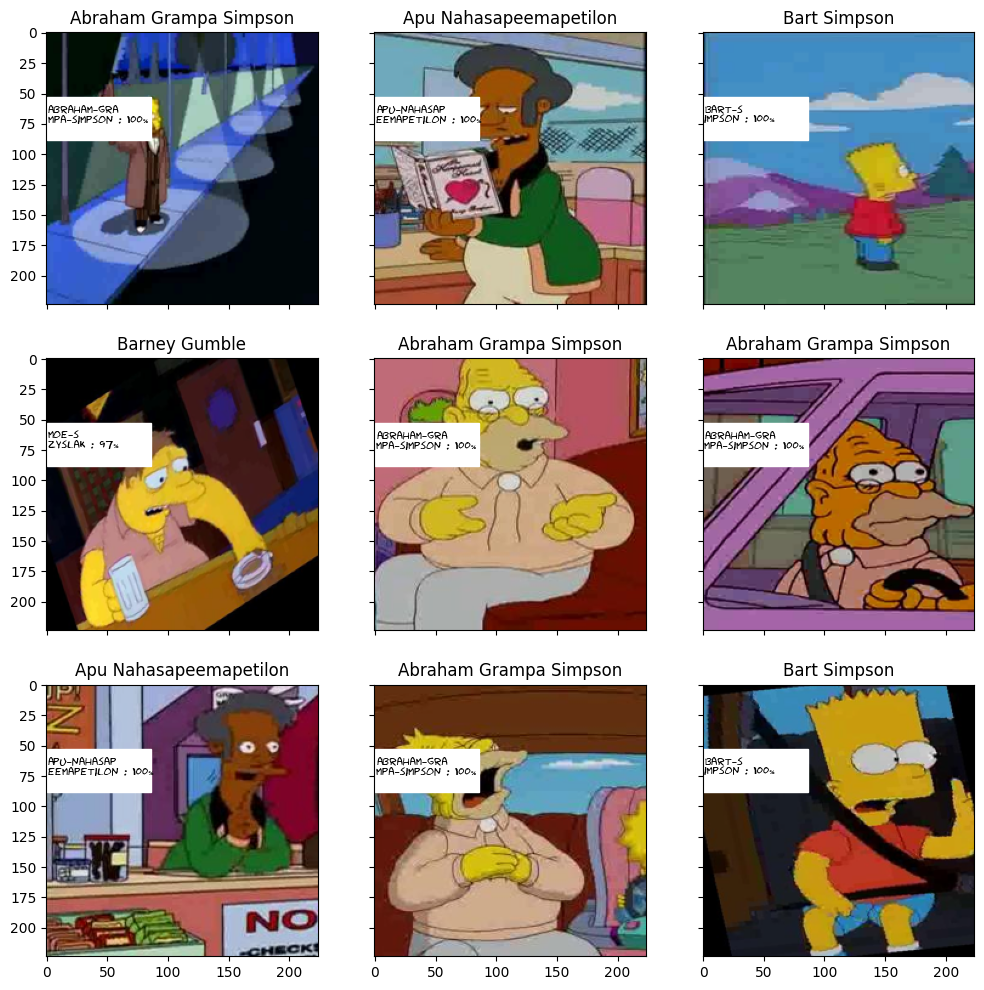

In [100]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,4000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(my_cnn_v2, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [101]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(my_cnn_v2, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [102]:
! ls

augmented_dataset  label_encoder.pkl


In [103]:
import pandas as pd
my_submit = pd.read_csv("/kaggle/input/journey-springfield/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.sample(5)

,Id,Expected
942,img947.jpg,sideshow_bob
159,img241.jpg,mayor_quimby
314,img381.jpg,sideshow_bob
262,img334.jpg,comic_book_guy
481,img531.jpg,comic_book_guy


In [104]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [105]:
my_submit.to_csv('/kaggle/working/my_cnn_v2.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:
1. Работа с датасетом:
* проверка (EDA) и предобработка;
* дополнение, выравниванике кол-ва картинок в классах - изменять можно как сами картинки, формируя новый датасет, или в класссе SimpsonsDataset;
* с помощью [аугментации](https://habr.com/ru/companies/smartengines/articles/264677/) или [без](https://www.geeksforgeeks.org/python-data-augmentation/);

2. Рабта с архитектурой сети:
* учим дольше и изменяем (подбираем) гиперпараметры: learning rate, batch size, нормализация картинки и вот это всё;
* добавление/удаление свёрточных слоёв;
* кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять!

3. Улучшение оптимизации:
* ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

4. Файнтютинг и трансферлёнинг:
* ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

5. Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
